# YOLO Evaluation

In [1]:
import os
from os.path import join, basename
from glob import glob
from importlib import reload
import time

import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from PIL import Image
import torch
from torch.utils.data import DataLoader
from ultralytics import YOLO
import yaml
import shutil
import pandas as pd
import csv

import dataset
reload(dataset)
from dataset import DotaDataset

#### Project Parameters

In [2]:
DATA_DIR = "../04-Data"

In [3]:
class_to_idx = {
           "ship" : 0, 
           "storage-tank" : 1, 
           "baseball-diamond" : 2, 
           "tennis-court" : 3, 
           "basketball-court" : 4, 
           "ground-track-field" : 5, 
           "bridge" : 6, 
           "large-vehicle" : 7, 
           "small-vehicle" : 8, 
           "helicopter" : 9, 
           "swimming-pool" : 10, 
           "roundabout" : 11, 
           "soccer-ball-field" : 12, 
           "plane" : 13, 
           "harbor" : 14,
           "container-crane" : 15}
idx_to_class = {
           0 : "ship", 
           1 : "storage-tank", 
           2 : "baseball-diamond", 
           3 : "tennis-court", 
           4 : "basketball-court", 
           5 : "ground-track-field", 
           6 : "bridge", 
           7 : "large-vehicle", 
           8 : "small-vehicle", 
           9 :"helicopter", 
           10 : "swimming-pool", 
           11 : "roundabout", 
           12 : "soccer-ball-field", 
           13 :"plane", 
           14 : "harbor",
           15 : "container-crane"}

#### Locate images and targets

In [4]:
test_targets_path = os.path.join(DATA_DIR,"patches_1024",'test_targets_patches')
test_images_path = os.path.join(DATA_DIR,'patches_1024', "test_images_patches")

test_images_list = glob(join(test_images_path, "**", "*.png"),recursive=True)
test_images_list = natsorted(test_images_list, key=lambda y: y.lower())
test_targets_list = glob(join(test_targets_path, "**", "*.txt"),recursive=True)
test_targets_list = natsorted(test_targets_list, key=lambda y: y.lower())

In [5]:
print(f"Test images: {len(test_images_list)}")
print(f"Test targets: {len(test_targets_list)}")

Test images: 2279
Test targets: 2279


#### Extract target information

In [6]:
def extract_hbb(pxl_coordinates: list):
    '''
    Creates a dictionary of bounding box information and returns a list of dictionaries containing bounding box information

    pxl_coordinates: List of strings
    '''
    bounding_boxes=[]
    for location in pxl_coordinates: 
        parts = location.strip().split()
        bounding_boxes.append({'label': parts[-2],
                              'x1': float(parts[0]), # x_min
                              'y1': float(parts[1]), # y_min
                              'x2': float(parts[2]), 
                              'y2': float(parts[3]), 
                              'x3': float(parts[4]), # x_max
                              'y3': float(parts[5]), # y_max
                              'x4': float(parts[6]), 
                              'y4': float(parts[7]), 
                              'difficulty': int(parts[-1])})
    return bounding_boxes

In [7]:
def read_txt(path):
    '''
    Reads .txt files and returns a list of strings (lines of the .txt file)

    path: Path to .txt file
    '''
    with open(path, 'r') as file:
        lines = file.readlines()
    return lines

#### Load trained model

In [8]:
model = YOLO("../best_baseline.pt")

#### Calculate Precision and Recall for a confidence threshold

In [9]:
def calculate_iou(box1, box2):
    """
    Calculates the IoU between two bounding boxes.
    """
    x_min_inter = torch.max(box1[0], box2[0])
    y_min_inter = torch.max(box1[1], box2[1])
    x_max_inter = torch.min(box1[2], box2[2])
    y_max_inter = torch.min(box1[3], box2[3])
    
    inter_area = (x_max_inter - x_min_inter).clamp(0) * (y_max_inter - y_min_inter).clamp(0)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    
    if union_area == 0:
        return 0.0  
        
    iou = inter_area / union_area
    return iou

In [8]:
def write_to_csv_pr_curve(prec_recall_per_class_threshold, iou_threshold, name = "precision_recall_curve"):
    '''
    Creates csv data for precision-recall curves.
    '''
    save_dir = "Precision-Recall-Curve"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    file_name = os.path.join(save_dir, name + ".csv")
    fieldnames = ['class','iou threshold', 'confidence threshold', 'precision', 'recall']
    
    with open(file_name, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for cls, threshold_dict in prec_recall_per_class_threshold.items():
            for threshold, metrics in threshold_dict.items():
                row = {'class': cls, 
                       'iou threshold': iou_threshold, 
                       'confidence threshold': threshold,
                        **metrics}
                writer.writerow(row)
            
    print(f'Data saved to {file_name}')

In [9]:
def write_to_csv_pr(prec_recall_per_class, iou_threshold, confidence_threshold, name = "precision_recall"):
    '''
    Creates csv data for precision and recall metrics.
    '''
    save_dir = "Precision-Recall"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    file_name = os.path.join(save_dir, name + ".csv")
    fieldnames = ['class','iou threshold', 'confidence threshold', 'precision', 'recall', 'f1']
    
    with open(file_name, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for cls, metrics in prec_recall_per_class.items():
            row = {'class': cls, 
                   'iou threshold': iou_threshold, 
                   'confidence threshold': confidence_threshold,  
                   **metrics}
            writer.writerow(row)
            
    print(f'Data saved to {file_name}')

In [21]:
def classify_predictions(targets, predictions, iou_threshold=0.5, confidence_threshold=0.5):
    '''
    Classifies the predictions of a given prediction according to the target. 
    Returns TP, FP and FN of prediction per difficulty.
    '''
    matched_predictions = set()
    classes = [
        "ship", "storage-tank", "baseball-diamond", "tennis-court", 
        "basketball-court", "ground-track-field", "bridge", 
        "large-vehicle", "small-vehicle", "helicopter", "swimming-pool", 
        "roundabout", "soccer-ball-field", "plane", "harbor", 
        "container-crane"
    ]
    metrics_per_class = {cls: {"TP": 0, "FP": 0, "FN": 0} for cls in classes}
    metrics_per_class_diff = {cls: {"TP": 0, "FP": 0, "FN": 0} for cls in classes}
    metrics_per_class_easy = {cls: {"TP": 0, "FP": 0, "FN": 0} for cls in classes}

    # CASE 1: No targets -> All predictions are FP
    # Consideration: If there are no targets, we dont know if difficult or not 
    if targets.numel() == 0:
        for pred in predictions:
            if pred[4] >= confidence_threshold:
                predicted_label = idx_to_class[int(pred[5])]
                metrics_per_class[predicted_label]["FP"] += 1
                metrics_per_class_diff[predicted_label]["FP"] += 1
                metrics_per_class_easy[predicted_label]["FP"] += 1
        return metrics_per_class, metrics_per_class_diff, metrics_per_class_easy
    
    # CASE 2: No predictions -> All targets are FN
    if predictions.numel() == 0:
        for target in targets:
            difficult = False
            if target[6] == 1:
                difficult = True
            true_label = idx_to_class[int(target[5])]
            metrics_per_class[true_label]["FN"] += 1
            if difficult:
                metrics_per_class_diff[true_label]["FN"] += 1
            else:
                metrics_per_class_easy[true_label]["FN"] += 1
        return metrics_per_class, metrics_per_class_diff, metrics_per_class_easy

    # CASE 3: Matching predictions -> Either TP or FN
    valid_predictions = [pred for pred in predictions if pred[4] >= confidence_threshold]
    valid_predictions.sort(key=lambda x: x[4], reverse=True)

    for target in targets:
        best_iou = 0
        best_j = -1
        true_label = target[5]
        difficult = False
        if target[6] == 1:
            difficult = True
        for j, pred in enumerate(valid_predictions):
            iou = calculate_iou(target, pred)
            pred_label = pred[5]
            if pred_label == true_label and iou > best_iou:
                best_iou = iou
                best_j = j
                
        if best_j != -1 and best_iou >= iou_threshold:
            predicted_label = valid_predictions[best_j].tolist()[5]
            if best_j not in matched_predictions: # So that one prediction can only predict one instance
                predicted_label = idx_to_class[predicted_label]
                metrics_per_class[predicted_label]["TP"] += 1
                matched_predictions.add(best_j)
                if difficult:
                    metrics_per_class_diff[predicted_label]["TP"] += 1
                else:
                    metrics_per_class_easy[predicted_label]["TP"] += 1
        else:
            true_label = idx_to_class[true_label.item()]
            metrics_per_class[true_label]["FN"] += 1
            if difficult:
                metrics_per_class_diff[true_label]["FN"] += 1
            else:
                metrics_per_class_easy[true_label]["FN"] += 1

    # CASE 4: Not matching predictions -> Duplicates Rest is FP
    for j, pred in enumerate(valid_predictions):
        predicted_label = pred.tolist()[5]
        predicted_label = idx_to_class[predicted_label]
        if j not in matched_predictions:
            metrics_per_class[predicted_label]["FP"] += 1
            if difficult:
                metrics_per_class_diff[predicted_label]["FP"] += 1
            else:
                metrics_per_class_easy[predicted_label]["FP"] += 1

    return metrics_per_class, metrics_per_class_diff, metrics_per_class_easy

#### Classification Process

1) No targets --> All predictions are FP for predicted class --> END
2) No predictions --> All targets are FN for true class --> END
3) Targets and Predictions available --> For target in targets: Find prediction with **highest IoU** score that **correctly classifies** the target
   1) FOUND
       1) Check if IoU surpasses IoU threshold
       2) Prediction is TP for predicted class 
       3) Mark prediction as matched (cannot be used again to match a target)
   2) NOT FOUND
       1) Target is FN for true class
4) All unmatched predictions either
   1) Did not classify correctly -> FP for predicted class
   2) Have a too low IoU threshold -> FP for predicted class
  
- ALL valid predictions surpass the confidence threshold
- For every target:
    - For every prediction: 
        - For all predictions IoU < IoU-threshold -> FN for true class
        - IoU > IoU-threshold and wrong classfication -> FP for predicted class
        - IoU > IoU-threshold and correct classfication -> TP for predicted class
        - For all targets IoU < IoU-threshold -> FP for predicted class

In [13]:
class ObjectDetectionRunningScore():
    '''
    Class to update and get metrics.
    '''
    def __init__(self):
        self.classes = [
        "ship", "storage-tank", "baseball-diamond", "tennis-court", 
        "basketball-court", "ground-track-field", "bridge", 
        "large-vehicle", "small-vehicle", "helicopter", "swimming-pool", 
        "roundabout", "soccer-ball-field", "plane", "harbor", 
        "container-crane"]
        self.confidence_thresholds = np.arange(0.0, 1.01, 0.01)
        self.confidence_thresholds = self.confidence_thresholds[::-1]
        self.metrics_per_class = {cls: {"TP": 0, "FP": 0, "FN": 0} for cls in self.classes}
        self.pr_metrics_per_class = {
            cls: {round(threshold, 2): {"TP": 0, "FP": 0, "FN": 0} for threshold in self.confidence_thresholds}
            for cls in self.classes}

    def update(self, update_dict):
        for cls, metric_dict in update_dict.items():
            self.metrics_per_class[cls]["TP"] += metric_dict.get("TP", 0)
            self.metrics_per_class[cls]["FP"] += metric_dict.get("FP", 0)
            self.metrics_per_class[cls]["FN"] += metric_dict.get("FN", 0)
    
    def get_metrics(self):
        metrics = {}
        for cls, metric_dict in self.metrics_per_class.items():
            tp = metric_dict["TP"]
            fp = metric_dict["FP"]
            fn = metric_dict["FN"]
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            metrics[cls] = {"precision": precision, "recall": recall, "f1": f1}
        return metrics

    def update_pr_curve(self, update_dict):
        for cls, threshold_dict in self.pr_metrics_per_class.items():
            for threshold, metric_dict in threshold_dict.items():
                self.pr_metrics_per_class[cls][threshold]["TP"] += update_dict[cls][threshold]["TP"]
                self.pr_metrics_per_class[cls][threshold]["FP"] += update_dict[cls][threshold]["FP"]
                self.pr_metrics_per_class[cls][threshold]["FN"] += update_dict[cls][threshold]["FN"]

    def get_pr_curves(self):
        precision_recall_dict = {
            cls: {round(threshold, 2): {"precision": [], "recall": []} for threshold in self.confidence_thresholds} 
            for cls in self.classes
        }
        for cls, threshold_dict in self.pr_metrics_per_class.items():
            for threshold, metric_dict in threshold_dict.items():
                tp = metric_dict["TP"]
                fp = metric_dict["FP"]
                fn = metric_dict["FN"]
                precision = tp / (tp + fp) if (tp + fp) > 0 else 1
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                
                precision_recall_dict[cls][threshold]["precision"] = precision
                precision_recall_dict[cls][threshold]["recall"] = recall
        return precision_recall_dict

    def compute_class_metrics(self):
        class_metrics = {cls: {"Total": 0, "TP": 0, "FP": 0, "FN": 0} for cls in self.classes}
        for cls, threshold_dict in self.pr_metrics_per_class.items():
            for threshold, metric_dict in threshold_dict.items():
                class_metrics[cls]["TP"] += metric_dict["TP"]
                class_metrics[cls]["FP"] += metric_dict["FP"]
                class_metrics[cls]["FN"] += metric_dict["FN"]
                class_metrics[cls]["Total"] += metric_dict["TP"] + metric_dict["FP"] + metric_dict["FN"]
        return class_metrics

In [10]:
def target_to_yolo_val_tensor(path):
    '''
    Transforms a target txt file to the same format as yolo predictions for easier comparison.
    '''
    lines = read_txt(path)
    bb_list = extract_hbb(lines)
    if len(bb_list) != 0:
        data = torch.zeros(len(bb_list), 7)
        for i, bb_dict in enumerate(bb_list):
            x_min = bb_dict["x1"] 
            y_min = bb_dict["y1"] 
            x_max = bb_dict["x3"]  
            y_max = bb_dict["y3"] 
            label = bb_dict["label"]
            difficulty = bb_dict["difficulty"]
            conf = 1.0
            bb_data = torch.tensor([x_min, y_min, x_max, y_max, conf, class_to_idx[label], difficulty])
            data[i] = bb_data
    else:
        return torch.tensor([])
    return data

In [11]:
def csv_to_dict(csv_file_path):
    '''
    Creates a dictionary from a csv file.
    '''
    df = pd.read_csv(csv_file_path)
    result_dict = {}
    for obj_class in df['class'].unique():
        class_df = df[df['class'] == obj_class]
        class_dict = {}
        for _, row in class_df.iterrows():
            confidence = row['confidence threshold']
            precision = row['precision']
            recall = row['recall']
            class_dict[confidence] = {'precision': precision, 'recall': recall}
        result_dict[obj_class] = class_dict
    return result_dict

In [14]:
def calculate_precision_recall(
    model, 
    iou_threshold = 0.5, 
    conf_threshold = 0.5, 
    max_images = -1,
    save_interval = 100):
    '''
    Calculates precision and recall per class and difficulty.
    '''
    start_time = time.time()
    all_metrics = ObjectDetectionRunningScore()
    easy_metrics = ObjectDetectionRunningScore()
    hard_metrics = ObjectDetectionRunningScore()
    
    print("Calculating metrics per class:")
    for i, paths in enumerate(zip(test_images_list, test_targets_list)):
        if i+1 != len(test_targets_list):
            print(f"{i+1}/{len(test_targets_list)}", end = "\r")
            
        image_path = paths[0]
        target_path = paths[1]
        
        prediction = model([image_path], verbose = False)
        yolo_prediction = prediction[0].boxes.data
        yolo_target = target_to_yolo_test_tensor(target_path)

        dict, dict_diff, dict_easy = classify_predictions(
            yolo_target, 
            yolo_prediction, 
            iou_threshold = iou_threshold, 
            confidence_threshold = conf_threshold)
        
        all_metrics.update(dict)
        easy_metrics.update(dict_easy)
        hard_metrics.update(dict_diff)
        if i%save_interval == 0 and i != 0:
            print(f"{i+1}/{len(test_images_list)}")
            all_pr = all_metrics.get_metrics()
            easy_pr = easy_metrics.get_metrics()
            hard_pr = hard_metrics.get_metrics()
            write_to_csv_pr(all_pr, iou_threshold, conf_threshold, "all_pr")
            write_to_csv_pr(easy_pr, iou_threshold, conf_threshold, "easy_pr")
            write_to_csv_pr(hard_pr, iou_threshold, conf_threshold, "hard_pr")
        if i+1 == max_images:
            break

    print(f"{i+1}/{len(test_images_list)}")
    all_pr = all_metrics.get_metrics()
    easy_pr = easy_metrics.get_metrics()
    hard_pr = hard_metrics.get_metrics()

    write_to_csv_pr(all_pr, iou_threshold, conf_threshold, "all_pr")
    write_to_csv_pr(easy_pr, iou_threshold, conf_threshold, "easy_pr")
    write_to_csv_pr(hard_pr, iou_threshold, conf_threshold, "hard_pr")
    
    duration = time.time() - start_time
    print(f"Duration: {round(duration/60)} minutes")
    print("DONE\n")
   
    return all_pr, easy_pr, hard_pr

In [74]:
#pr_all, pr_easy, pr_hard = calculate_precision_recall(
    model, 
    conf_threshold = 0.5, 
    save_interval = 100)

Calculating metrics per class:
101/7155
Data saved to Precision-Recall/all_pr.csv
Data saved to Precision-Recall/easy_pr.csv
Data saved to Precision-Recall/hard_pr.csv
201/7155
Data saved to Precision-Recall/all_pr.csv
Data saved to Precision-Recall/easy_pr.csv
Data saved to Precision-Recall/hard_pr.csv
301/7155
Data saved to Precision-Recall/all_pr.csv
Data saved to Precision-Recall/easy_pr.csv
Data saved to Precision-Recall/hard_pr.csv
401/7155
Data saved to Precision-Recall/all_pr.csv
Data saved to Precision-Recall/easy_pr.csv
Data saved to Precision-Recall/hard_pr.csv
501/7155
Data saved to Precision-Recall/all_pr.csv
Data saved to Precision-Recall/easy_pr.csv
Data saved to Precision-Recall/hard_pr.csv
601/7155
Data saved to Precision-Recall/all_pr.csv
Data saved to Precision-Recall/easy_pr.csv
Data saved to Precision-Recall/hard_pr.csv
701/7155
Data saved to Precision-Recall/all_pr.csv
Data saved to Precision-Recall/easy_pr.csv
Data saved to Precision-Recall/hard_pr.csv
801/7155
D

In [75]:
df_all = pd.read_csv("Precision-Recall/all_pr.csv")
sorted_df_ascending = df_all.sort_values(by='f1', ascending=False)
sorted_df_ascending

,class,iou threshold,confidence threshold,precision,recall,f1
3,tennis-court,0.5,0.5,0.981744,0.846154,0.908920
0,ship,0.5,0.5,0.984774,0.632483,0.770258
13,plane,0.5,0.5,0.968668,0.631489,0.764554
1,storage-tank,0.5,0.5,0.983146,0.535988,0.693756
7,large-vehicle,0.5,0.5,0.929374,0.347748,0.506119
8,small-vehicle,0.5,0.5,0.806136,0.329443,0.467737
10,swimming-pool,0.5,0.5,0.891720,0.258303,0.400572
4,basketball-court,0.5,0.5,1.000000,0.150943,0.262295
14,harbor,0.5,0.5,0.896364,0.132884,0.231455
6,bridge,0.5,0.5,1.000000,0.128205,0.227273


In [76]:
df_diff = pd.read_csv("Precision-Recall/hard_pr.csv")
sorted_df_ascending = df_diff.sort_values(by='f1', ascending=False)
sorted_df_ascending

,class,iou threshold,confidence threshold,precision,recall,f1
3,tennis-court,0.5,0.5,1.000000,0.200000,0.333333
5,ground-track-field,0.5,0.5,1.000000,0.200000,0.333333
8,small-vehicle,0.5,0.5,0.727604,0.189426,0.300594
13,plane,0.5,0.5,0.153846,0.333333,0.210526
0,ship,0.5,0.5,0.890909,0.104925,0.187739
1,storage-tank,0.5,0.5,0.913043,0.101449,0.182609
7,large-vehicle,0.5,0.5,0.923077,0.093023,0.169014
2,baseball-diamond,0.5,0.5,0.000000,0.000000,0.000000
4,basketball-court,0.5,0.5,0.000000,0.000000,0.000000
6,bridge,0.5,0.5,0.000000,0.000000,0.000000


In [77]:
df_easy = pd.read_csv("Precision-Recall/easy_pr.csv")
sorted_df_ascending = df_easy.sort_values(by='f1', ascending=False)
sorted_df_ascending

,class,iou threshold,confidence threshold,precision,recall,f1
3,tennis-court,0.5,0.5,0.981707,0.851852,0.912181
1,storage-tank,0.5,0.5,0.985030,0.737668,0.843590
0,ship,0.5,0.5,0.985308,0.649281,0.782755
13,plane,0.5,0.5,0.977543,0.633020,0.768432
8,small-vehicle,0.5,0.5,0.732929,0.569850,0.641182
7,large-vehicle,0.5,0.5,0.929508,0.369141,0.528425
10,swimming-pool,0.5,0.5,0.915033,0.291667,0.442338
4,basketball-court,0.5,0.5,1.000000,0.160000,0.275862
6,bridge,0.5,0.5,1.000000,0.138889,0.243902
14,harbor,0.5,0.5,0.896364,0.133895,0.232987


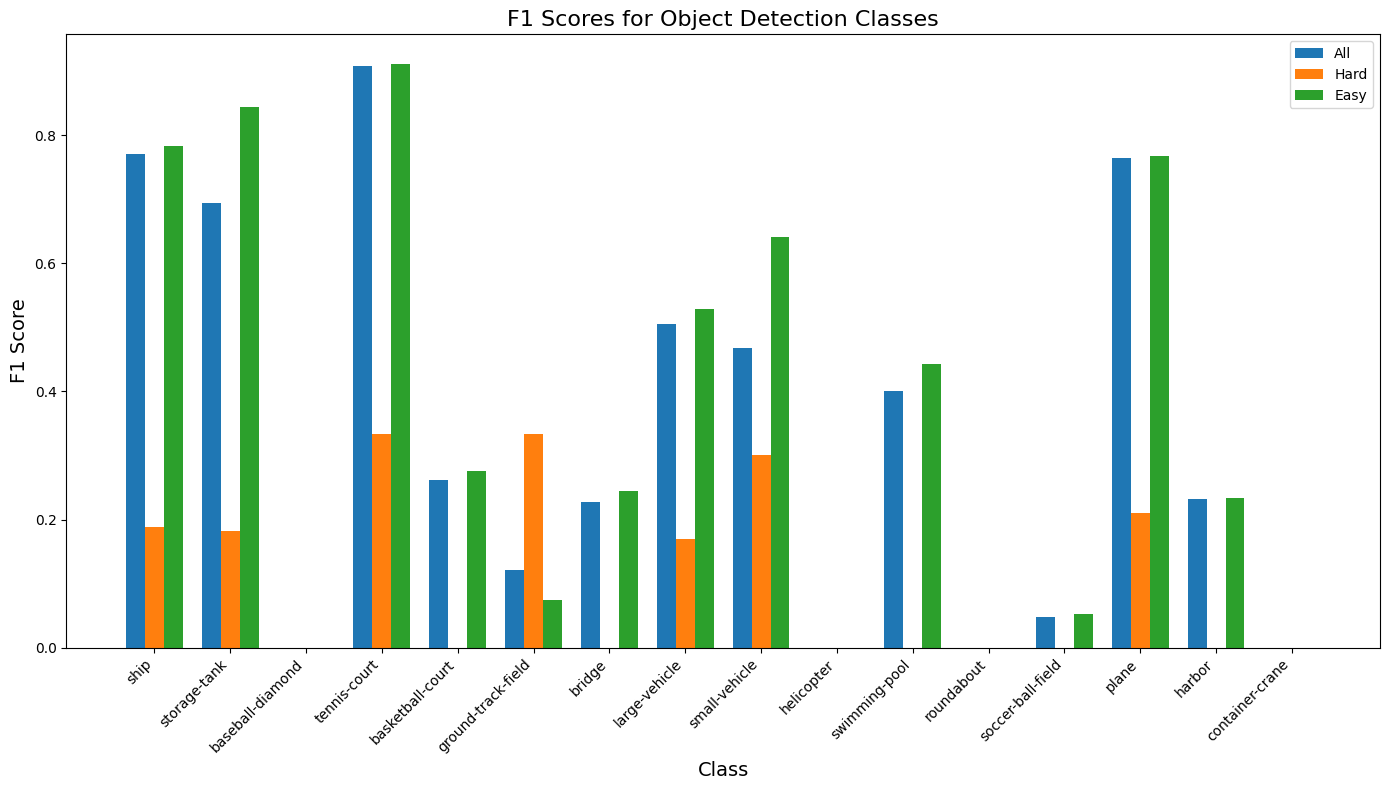

In [78]:
df_all = pd.read_csv("Precision-Recall/all_pr.csv")
df_diff = pd.read_csv("Precision-Recall/hard_pr.csv")
df_easy = pd.read_csv("Precision-Recall/easy_pr.csv")

merged_df = df_all.merge(df_diff, on='class', suffixes=('_df1', '_df2')).merge(df_easy, on='class')
merged_df = merged_df.rename(columns={'f1': 'f1_df3'})
fig, ax = plt.subplots(figsize=(14, 8))

bar_width = 0.25
indices = np.arange(len(merged_df['class']))

bar1 = ax.bar(indices, merged_df['f1_df1'], width=bar_width, label='All', align='center')
bar2 = ax.bar(indices + bar_width, merged_df['f1_df2'], width=bar_width, label='Hard', align='center')
bar3 = ax.bar(indices + 2*bar_width, merged_df['f1_df3'], width=bar_width, label='Easy', align='center')

ax.set_xlabel('Class', fontsize=14)
ax.set_ylabel('F1 Score', fontsize=14)
ax.set_title('F1 Scores for Object Detection Classes', fontsize=16)
ax.set_xticks(indices + bar_width)
ax.set_xticklabels(merged_df['class'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

#### Calculate precision-recall curves

In [20]:
def calculate_precision_recall_curves(
    model, 
    test_images_list, 
    test_targets_list,
    iou_threshold = 0.5,
    save_interval = 100,
    sanity_check = [False, False, False], # All, diff, easy
    classes_sanity_check = [], 
    max_images = -1):
    '''
    Calculates precision and recall for every class per difficulty and confidence threshold.
    '''
    
    classes = [
        "ship", "storage-tank", "baseball-diamond", "tennis-court", 
        "basketball-court", "ground-track-field", "bridge", 
        "large-vehicle", "small-vehicle", "helicopter", "swimming-pool", 
        "roundabout", "soccer-ball-field", "plane", "harbor", 
        "container-crane"
    ]
    scores_all = ObjectDetectionRunningScore()
    scores_diff = ObjectDetectionRunningScore()
    scores_easy = ObjectDetectionRunningScore()
    counter_dict = {}
    confidence_thresholds = np.arange(0.0, 1.01, 0.01)
    confidence_thresholds = confidence_thresholds[::-1]
    metric_dict_all = {
        cls: {round(threshold, 2): {"TP": 0, "FP": 0, "FN": 0} for threshold in confidence_thresholds}
        for cls in classes
    }
    metric_dict_diff = {
        cls: {round(threshold, 2): {"TP": 0, "FP": 0, "FN": 0} for threshold in confidence_thresholds}
        for cls in classes
    }
    metric_dict_easy = {
        cls: {round(threshold, 2): {"TP": 0, "FP": 0, "FN": 0} for threshold in confidence_thresholds} 
        for cls in classes
    }
    start_time = time.time()
    print("Calculating Precision-Recall Curve per class:\n")
    for i, (image_path, target_path) in enumerate(zip(test_images_list, test_targets_list)):
        print(f"{i+1}/{len(test_images_list)}", end = "\r")
        
        prediction = model([image_path], verbose = False)
        yolo_prediction = prediction[0].boxes.data    
        yolo_target = target_to_yolo_test_tensor(target_path)
        
        if any(sanity_check):
            print(f"\nTarget path: {target_path}")
        if sanity_check[0]:
            print("TARGET for ALL")
            count_numbers_with_dict(yolo_target[:,5].tolist())
            print("PREDICTION for ALL")
            count_numbers_with_dict(prediction[0].boxes.cls.tolist())
        if sanity_check[1]:
            print("TARGET for HARD")
            mask = yolo_target[:, 6] == 1
            diff_yolo_target = yolo_target[mask]
            count_numbers_with_dict(diff_yolo_target[:,5].tolist())
            print("PREDICTION for ALL")
            count_numbers_with_dict(prediction[0].boxes.cls.tolist())
        if sanity_check[2]:
            print("TARGET for EASY")
            mask = yolo_target[:, 6] == 0
            easy_yolo_target = yolo_target[mask]
            count_numbers_with_dict(easy_yolo_target[:,5].tolist())
            print("PREDICTION for ALL")
            count_numbers_with_dict(prediction[0].boxes.cls.tolist())
        
        for threshold in confidence_thresholds:
            threshold = round(threshold, 2)
            dict_all, dict_diff, dict_easy = classify_predictions(yolo_target, 
                                                              yolo_prediction, 
                                                              iou_threshold = iou_threshold, 
                                                              confidence_threshold = threshold)
            
            if any(sanity_check):
                print(f"\nConfidence threshold = {threshold}")   
            if sanity_check[0]:
                print("ALL")
                filter_and_sum_non_zero_classes(dict_all)
            if sanity_check[1]:
                print("HARD")
                filter_and_sum_non_zero_classes(dict_diff)
            if sanity_check[2]:
                print("EASY")
                filter_and_sum_non_zero_classes(dict_easy)
                
            for cls, dict in dict_all.items():
                metric_dict_all[cls][threshold]["TP"] += dict.get('TP', 0) 
                metric_dict_all[cls][threshold]["FP"] += dict.get('FP', 0) 
                metric_dict_all[cls][threshold]["FN"] += dict.get('FN', 0)
                
                if sanity_check[0]:
                    if cls in classes_sanity_check:
                        print(f"Metrics for ALL class '{cls}':")
                        if cls not in counter_dict.keys():
                            counter_dict[cls] = {}
                        if "all" not in counter_dict[cls].keys():
                            counter_dict[cls]["all"] = {"counter_tp": 0, "counter_fp": 0, "counter_fn": 0}
                        counter_dict[cls]["all"]["counter_tp"] += dict["TP"]
                        counter_dict[cls]["all"]["counter_fp"] += dict["FP"]
                        counter_dict[cls]["all"]["counter_fn"] += dict["FN"]
                        
                        print(f"SUM -> TP: {counter_dict[cls]["all"]["counter_tp"]} FP: {counter_dict[cls]["all"]["counter_fp"]} FN:{counter_dict[cls]["all"]["counter_fn"]}")
                        print(f"UPDATE -> TP:{metric_dict_all[cls][threshold]["TP"]} FP: {metric_dict_all[cls][threshold]["FP"]} FN: {metric_dict_all[cls][threshold]["FN"]}")
                        print(f"Recall: {dict["TP"]/(dict["TP"]+dict["FN"]) if (dict["TP"]+dict["FN"]) > 0 else 0.0}")
                        print(f"Precision: {dict["TP"]/(dict["TP"]+dict["FP"]) if (dict["TP"]+dict["FP"]) > 0 else 1.0}")
               
            for cls, dict in dict_diff.items():
                metric_dict_diff[cls][threshold]["TP"] += dict.get('TP', 0) 
                metric_dict_diff[cls][threshold]["FP"] += dict.get('FP', 0) 
                metric_dict_diff[cls][threshold]["FN"] += dict.get('FN', 0)
                
                if sanity_check[1]:
                    if cls in classes_sanity_check:
                        print(f"Metrics for HARD class '{cls}':")
                        if cls not in counter_dict.keys():
                            counter_dict[cls] = {}
                        if "hard" not in counter_dict[cls].keys():
                            counter_dict[cls]["hard"] = {"counter_tp": 0, "counter_fp": 0, "counter_fn": 0}
                        counter_dict[cls]["hard"]["counter_tp"] += dict["TP"]
                        counter_dict[cls]["hard"]["counter_fp"] += dict["FP"]
                        counter_dict[cls]["hard"]["counter_fn"] += dict["FN"]
                        
                        print(f"SUM -> TP: {counter_dict[cls]["hard"]["counter_tp"]} FP: {counter_dict[cls]["hard"]["counter_fp"]} FN:{counter_dict[cls]["hard"]["counter_fn"]}")
                        print(f"UPDATE -> TP:{metric_dict_diff[cls][threshold]["TP"]} FP: {metric_dict_diff[cls][threshold]["FP"]} FN: {metric_dict_diff[cls][threshold]["FN"]}")
                        print(f"Recall: {dict["TP"]/(dict["TP"]+dict["FN"]) if (dict["TP"]+dict["FN"]) > 0 else 0.0}")
                        print(f"Precision: {dict["TP"]/(dict["TP"]+dict["FP"]) if (dict["TP"]+dict["FP"]) > 0 else 1.0}")
                
            for cls, dict in dict_easy.items():
                metric_dict_easy[cls][threshold]["TP"] += dict.get('TP', 0) 
                metric_dict_easy[cls][threshold]["FP"] += dict.get('FP', 0) 
                metric_dict_easy[cls][threshold]["FN"] += dict.get('FN', 0)
                
                if sanity_check[2]:
                    if cls in classes_sanity_check:
                        print(f"Metrics for EASY class '{cls}':")
                        if cls not in counter_dict.keys():
                            counter_dict[cls] = {}
                        if "easy" not in counter_dict[cls].keys():
                            counter_dict[cls]["easy"] = {"counter_tp": 0, "counter_fp": 0, "counter_fn": 0}
                        counter_dict[cls]["easy"]["counter_tp"] += dict["TP"]
                        counter_dict[cls]["easy"]["counter_fp"] += dict["FP"]
                        counter_dict[cls]["easy"]["counter_fn"] += dict["FN"]
                        
                        print(f"SUM -> TP: {counter_dict[cls]["easy"]["counter_tp"]} FP: {counter_dict[cls]["easy"]["counter_fp"]} FN:{counter_dict[cls]["easy"]["counter_fn"]}")
                        print(f"UPDATE -> TP:{metric_dict_easy[cls][threshold]["TP"]} FP: {metric_dict_easy[cls][threshold]["FP"]} FN: {metric_dict_easy[cls][threshold]["FN"]}")
                        print(f"Recall: {dict["TP"]/(dict["TP"]+dict["FN"]) if (dict["TP"]+dict["FN"]) > 0 else 0.0}")
                        print(f"Precision: {dict["TP"]/(dict["TP"]+dict["FP"]) if (dict["TP"]+dict["FP"]) > 0 else 1.0}")
        
        scores_all.update_pr_curve(metric_dict_all)
        scores_diff.update_pr_curve(metric_dict_diff)
        scores_easy.update_pr_curve(metric_dict_easy)
        if i%save_interval == 0 and i != 0:
            print(f"{i+1}/{len(test_images_list)}")
            sc_all = scores_all.get_pr_curves()
            sc_diff = scores_diff.get_pr_curves()
            sc_easy = scores_easy.get_pr_curves()
        
            write_to_csv_pr_curve(sc_all, iou_threshold, name = "all_pr_curve")
            write_to_csv_pr_curve(sc_diff, iou_threshold, name = "diff_pr_curve")
            write_to_csv_pr_curve(sc_easy, iou_threshold, name = "easy_pr_curve")
        if i+1 == max_images:
            break
            
    print(f"{i+1}/{len(test_images_list)}")
    sc_all = scores_all.get_pr_curves()
    sc_diff = scores_diff.get_pr_curves()
    sc_easy = scores_easy.get_pr_curves()

    write_to_csv_pr_curve(sc_all, iou_threshold, name = "all_pr_curve")
    write_to_csv_pr_curve(sc_diff, iou_threshold, name = "diff_pr_curve")
    write_to_csv_pr_curve(scores_easy, iou_threshold, name = "easy_pr_curve")
    
    duration = time.time() - start_time
    print(f"Duration: {round(duration/60)} minutes")
    print("DONE")
    
    return sc_all, sc_diff, sc_easy

In [82]:
sc_all, sc_diff, sc_easy = calculate_precision_recall_curves(
    model, 
    test_images_list, 
    test_targets_list,
    save_interval = 100,
    sanity_check = [False, False, False], #all hard easy
    classes_sanity_check = ["large-vehicle"],
    max_images = 2000)

Calculating Precision-Recall Curve per class:

101/7155
Data saved to Precision-Recall-Curve/all_pr_curve.csv
Data saved to Precision-Recall-Curve/diff_pr_curve.csv
Data saved to Precision-Recall-Curve/easy_pr_curve.csv
201/7155
Data saved to Precision-Recall-Curve/all_pr_curve.csv
Data saved to Precision-Recall-Curve/diff_pr_curve.csv
Data saved to Precision-Recall-Curve/easy_pr_curve.csv
301/7155
Data saved to Precision-Recall-Curve/all_pr_curve.csv
Data saved to Precision-Recall-Curve/diff_pr_curve.csv
Data saved to Precision-Recall-Curve/easy_pr_curve.csv
401/7155
Data saved to Precision-Recall-Curve/all_pr_curve.csv
Data saved to Precision-Recall-Curve/diff_pr_curve.csv
Data saved to Precision-Recall-Curve/easy_pr_curve.csv
501/7155
Data saved to Precision-Recall-Curve/all_pr_curve.csv
Data saved to Precision-Recall-Curve/diff_pr_curve.csv
Data saved to Precision-Recall-Curve/easy_pr_curve.csv
601/7155
Data saved to Precision-Recall-Curve/all_pr_curve.csv
Data saved to Precision-R

KeyboardInterrupt: 

In [83]:
df_all_curve = pd.read_csv("Precision-Recall-Curve/all_pr_curve.csv")
df_all_curve

,class,iou threshold,confidence threshold,precision,recall
0,ship,0.5,1.00,1.0,0.0
1,ship,0.5,0.99,1.0,0.0
2,ship,0.5,0.98,1.0,0.0
3,ship,0.5,0.97,1.0,0.0
4,ship,0.5,0.96,1.0,0.0
...,...,...,...,...,...
1611,container-crane,0.5,0.04,1.0,0.0
1612,container-crane,0.5,0.03,1.0,0.0
1613,container-crane,0.5,0.02,1.0,0.0
1614,container-crane,0.5,0.01,1.0,0.0


#### Sanity Check

In [12]:
def count_numbers_with_dict(numbers):
    '''
    Calculates the number of instances in a dict.
    '''
    counts = {}
    
    for number in numbers:
        if number in counts:
            counts[number] += 1
        else:
            counts[number] = 1
            
    for key, value in counts.items():
        print(idx_to_class[key], value, sep =  ": ")

In [13]:
def filter_and_sum_non_zero_classes(data):
    """
    Filter out classes with non-zero entries in the dictionary and compute the sum of TP, FP, and FN.
    """
    non_zero_classes = {}

    for class_name, metrics in data.items():
        total_sum = sum(metrics.values())
        
        if total_sum > 0:
            non_zero_classes[class_name] = metrics
            non_zero_classes[class_name]['Total'] = total_sum

    for class_name, metrics in non_zero_classes.items():
        tp, fp, fn = metrics['TP'], metrics['FP'], metrics['FN']
        total = tp + fp + fn
        print(f"{class_name}: TP={tp}, FP={fp}, FN={fn}, Total={total}")

#### Visualize Precision Recall Curves

In [30]:
from itertools import zip_longest
def show_pr_curves(
    sc_bl_all = None, 
    sc_bl_diff = None, 
    sc_bl_easy = None,
    sc_os_all = None,
    sc_os_diff = None,
    sc_os_easy = None,
    sc_aug_all = None,
    sc_aug_diff = None,
    sc_aug_easy = None):
    
    classes = [
        "ship", "storage-tank", "baseball-diamond", "tennis-court", 
        "basketball-court", "ground-track-field", "bridge", 
        "large-vehicle", "small-vehicle", "helicopter", "swimming-pool", 
        "roundabout", "soccer-ball-field", "plane", "harbor", 
        "container-crane"
    ]
    score_list_bl = []
    score_list_os = []
    score_list_aug = []
    split_name = []
    
    if sc_bl_all is not None:
        score_list_bl.append(sc_bl_all)
        split_name.append("All")
    if sc_bl_diff is not None:
        score_list_bl.append(sc_bl_diff)
        split_name.append("HTD")
    if sc_bl_easy is not None:
        score_list_bl.append(sc_bl_easy)
        split_name.append("ETD")
    if sc_os_all is not None:
        score_list_os.append(sc_os_all)
    if sc_os_diff is not None:
        score_list_os.append(sc_os_diff)
    if sc_os_easy is not None:
        score_list_os.append(sc_os_easy)
    if sc_aug_all is not None:
        score_list_aug.append(sc_aug_all)
    if sc_aug_diff is not None:
        score_list_aug.append(sc_aug_diff)
    if sc_aug_easy is not None:
        score_list_aug.append(sc_aug_easy)

    for i, (score_set_bl, score_set_os, score_set_aug) in enumerate(zip_longest(score_list_bl, score_list_os, score_list_aug)):
        precision_class_dict_bl = {}
        recall_class_dict_bl = {}
        precision_class_dict_os = {}
        recall_class_dict_os = {}
        precision_class_dict_aug = {}
        recall_class_dict_aug = {}
        
        for cls, threshold_dict in score_set_bl.items():
            if cls not in precision_class_dict_bl:
                precision_class_dict_bl[cls] = []
            if cls not in recall_class_dict_bl:
                recall_class_dict_bl[cls] = []
                
            for threshold, metric_dict in threshold_dict.items():
                precision = metric_dict["precision"]
                recall = metric_dict["recall"]
                precision_class_dict_bl[cls].append(precision)
                recall_class_dict_bl[cls].append(recall)

        for cls, threshold_dict in score_set_os.items():
            if cls not in precision_class_dict_os:
                precision_class_dict_os[cls] = []
            if cls not in recall_class_dict_os:
                recall_class_dict_os[cls] = []
                
            for threshold, metric_dict in threshold_dict.items():
                precision = metric_dict["precision"]
                recall = metric_dict["recall"]
                precision_class_dict_os[cls].append(precision)
                recall_class_dict_os[cls].append(recall)

        for cls, threshold_dict in score_set_aug.items():
            if cls not in precision_class_dict_aug:
                precision_class_dict_aug[cls] = []
            if cls not in recall_class_dict_aug:
                recall_class_dict_aug[cls] = []
                
            for threshold, metric_dict in threshold_dict.items():
                precision = metric_dict["precision"]
                recall = metric_dict["recall"]
                precision_class_dict_aug[cls].append(precision)
                recall_class_dict_aug[cls].append(recall)

        fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))  
        fig.tight_layout(pad=3.0)
        axes = axes.flatten()
        for j, cls in enumerate(classes):
            recall_list_bl = recall_class_dict_bl[cls]
            precision_list_bl = precision_class_dict_bl[cls]
            recall_list_os = recall_class_dict_os[cls]
            precision_list_os = precision_class_dict_os[cls]
            recall_list_aug = recall_class_dict_aug[cls]
            precision_list_aug = precision_class_dict_aug[cls]
            ax = axes[j]
            title = f"{split_name[i]} {cls}"
           
            ax.plot(recall_list_bl, precision_list_bl, label='Baseline', color='blue')
            ax.plot(recall_list_os, precision_list_os, label='Oversample', color='green')
            ax.plot(recall_list_aug, precision_list_aug, label='Oversample', color='red')
            ax.set_title(f"{split_name[i]} {cls}")
            ax.grid(True)
            ax.set_xlim(-0.05,1.05)
            ax.set_ylim(-0.05,1.05)
            ax.set_xlabel("Recall")
            ax.set_ylabel("Precision")

        plt.savefig(f"PR_CURVE_IMAGES/{split_name[i]}")
        plt.show() 

In [31]:
csv_bl_all = "../RESULTS_baseline/Precision-Recall-Curve/all_pr_curve.csv"
csv_bl_easy = "../RESULTS_baseline/Precision-Recall-Curve/easy_pr_curve.csv"
csv_bl_hard = "../RESULTS_baseline/Precision-Recall-Curve/diff_pr_curve.csv"

csv_os_all  = "../RESULTS_oversampling/Precision-Recall-Curve/all_pr_curve.csv"
csv_os_easy = "../RESULTS_oversampling/Precision-Recall-Curve/easy_pr_curve.csv"
csv_os_hard = "../RESULTS_oversampling/Precision-Recall-Curve/diff_pr_curve.csv"

csv_aug_all  = "../RESULTS_augment_final/Precision-Recall-Curve/all_pr_curve.csv"
csv_aug_easy = "../RESULTS_augment_final/Precision-Recall-Curve/easy_pr_curve.csv"
csv_aug_hard = "../RESULTS_augment_final/Precision-Recall-Curve/diff_pr_curve.csv"

In [32]:
sc_all_bl = csv_to_dict(csv_bl_all)
sc_diff_bl = csv_to_dict(csv_bl_hard)
sc_easy_bl = csv_to_dict(csv_bl_easy)

sc_all_os = csv_to_dict(csv_os_all)
sc_diff_os = csv_to_dict(csv_os_hard)
sc_easy_os = csv_to_dict(csv_os_easy)

sc_all_aug = csv_to_dict(csv_aug_all)
sc_diff_aug = csv_to_dict(csv_aug_hard)
sc_easy_aug = csv_to_dict(csv_aug_easy)

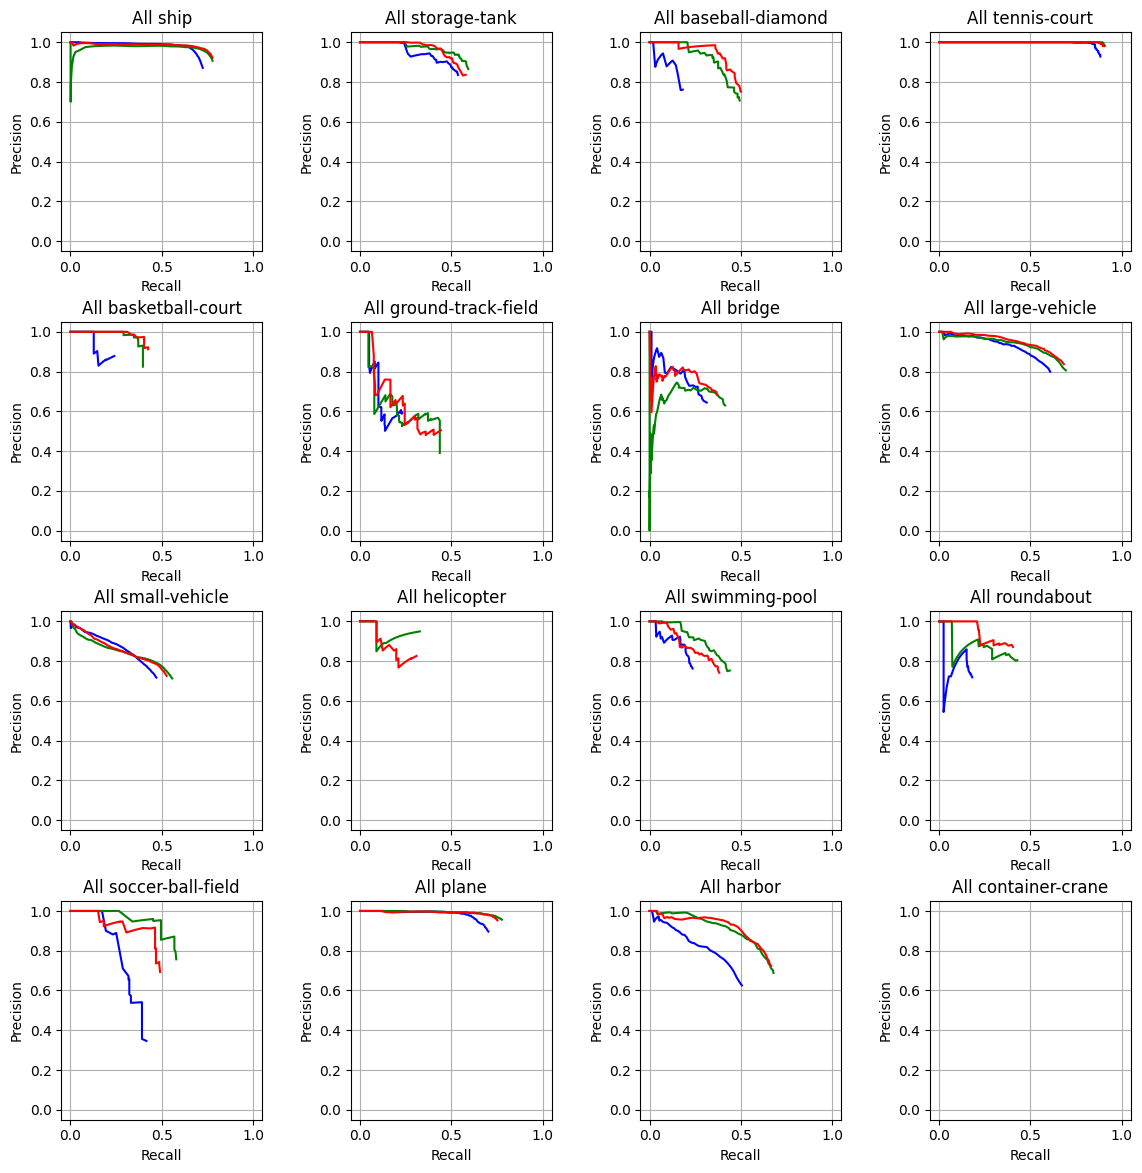

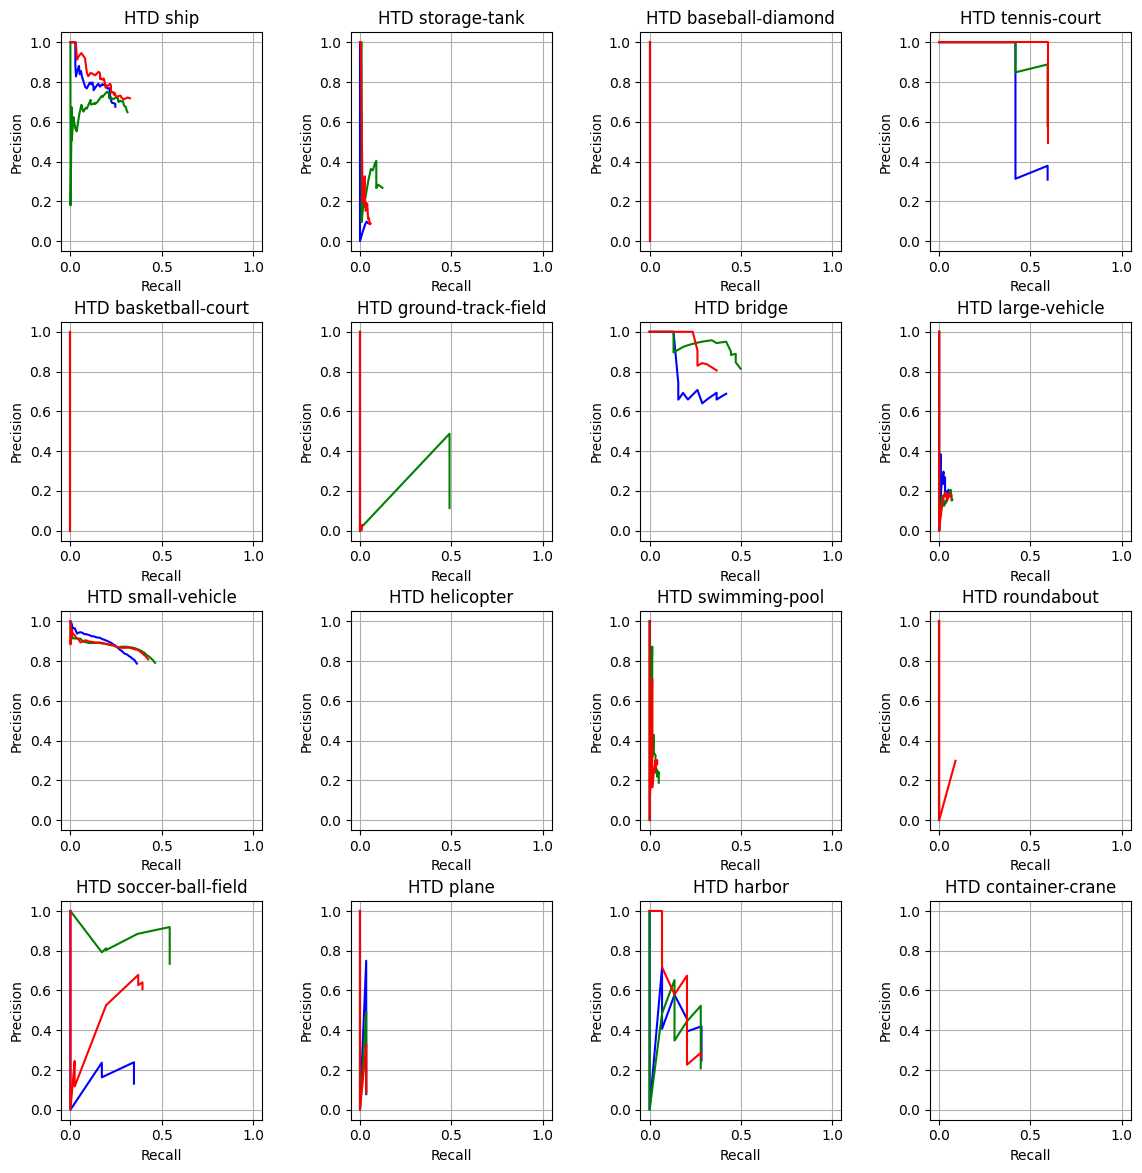

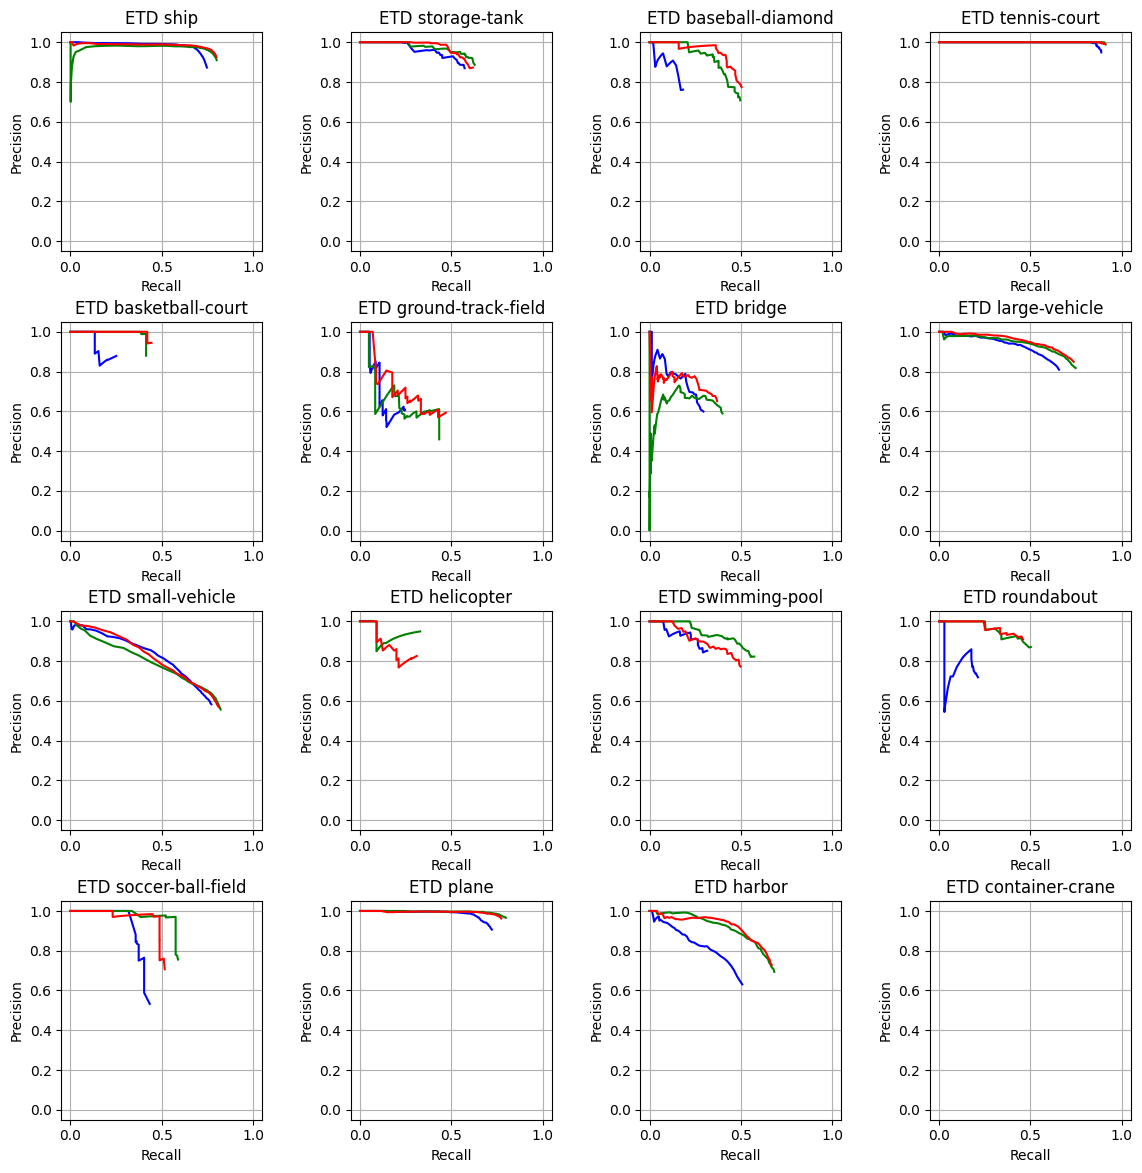

In [33]:
show_pr_curves(
    sc_bl_all = sc_all_bl,
    sc_bl_diff = sc_diff_bl, 
    sc_bl_easy = sc_easy_bl,
sc_os_all = sc_all_os,
sc_os_diff = sc_diff_os,
sc_os_easy =sc_easy_os,
sc_aug_all = sc_all_aug,
sc_aug_diff = sc_diff_aug,
sc_aug_easy = sc_easy_aug)

In [37]:
def show_pr_curve(score_set_bl = None,
                  score_set_os = None,
                  score_set_aug = None,
                  class_name = None):
    classes = [
        "ship", "storage-tank", "baseball-diamond", "tennis-court", 
        "basketball-court", "ground-track-field", "bridge", 
        "large-vehicle", "small-vehicle", "helicopter", "swimming-pool", 
        "roundabout", "soccer-ball-field", "plane", "harbor", 
        "container-crane"]
    precision_class_dict_bl = {}
    recall_class_dict_bl = {}
    precision_class_dict_os = {}
    recall_class_dict_os = {}
    precision_class_dict_aug = {}
    recall_class_dict_aug = {}
    
    for cls, threshold_dict in score_set_bl.items():
        if cls not in precision_class_dict_bl:
            precision_class_dict_bl[cls] = []
        if cls not in recall_class_dict_bl:
            recall_class_dict_bl[cls] = []
            
        for threshold, metric_dict in threshold_dict.items():
            precision = metric_dict["precision"]
            recall = metric_dict["recall"]
            precision_class_dict_bl[cls].append(precision)
            recall_class_dict_bl[cls].append(recall)

    for cls, threshold_dict in score_set_os.items():
        if cls not in precision_class_dict_os:
            precision_class_dict_os[cls] = []
        if cls not in recall_class_dict_os:
            recall_class_dict_os[cls] = []
            
        for threshold, metric_dict in threshold_dict.items():
            precision = metric_dict["precision"]
            recall = metric_dict["recall"]
            precision_class_dict_os[cls].append(precision)
            recall_class_dict_os[cls].append(recall)

    for cls, threshold_dict in score_set_aug.items():
        if cls not in precision_class_dict_aug:
            precision_class_dict_aug[cls] = []
        if cls not in recall_class_dict_aug:
            recall_class_dict_aug[cls] = []
            
        for threshold, metric_dict in threshold_dict.items():
            precision = metric_dict["precision"]
            recall = metric_dict["recall"]
            precision_class_dict_aug[cls].append(precision)
            recall_class_dict_aug[cls].append(recall)

    recall_list_bl = recall_class_dict_bl[class_name]
    precision_list_bl = precision_class_dict_bl[class_name]
    recall_list_os = recall_class_dict_os[class_name]
    precision_list_os = precision_class_dict_os[class_name]
    recall_list_aug = recall_class_dict_aug[class_name]
    precision_list_aug = precision_class_dict_aug[class_name]
    if not os.path.exists("Hard_Images"):
        os.mkdir("Hard_Images")
    
    plt.figure(figsize=(8, 6))  
    plt.plot(recall_list_bl, precision_list_bl, linestyle='-', color='b', label='Baseline')
    plt.plot(recall_list_os, precision_list_os, linestyle='-', color='g', label='Oversampling')
    plt.plot(recall_list_aug, precision_list_aug, linestyle='-', color='r', label='Augmentation')
    plt.title(f"PR Curve {class_name} ALL")  
    plt.xlabel('Recall')  
    plt.ylabel('Precision')
    plt.xlim(-0.05, 1.05)  
    plt.ylim(-0.05, 1.05)
    plt.legend(loc='upper right')
    plt.grid(True)  
    plt.savefig(f"Hard_Images/{class_name}.png")
    plt.show()
    
    

Most hard to detect objects in descending order: 
- Small Vehicle
- Large Vehicle
- Ship
- Storage Tank

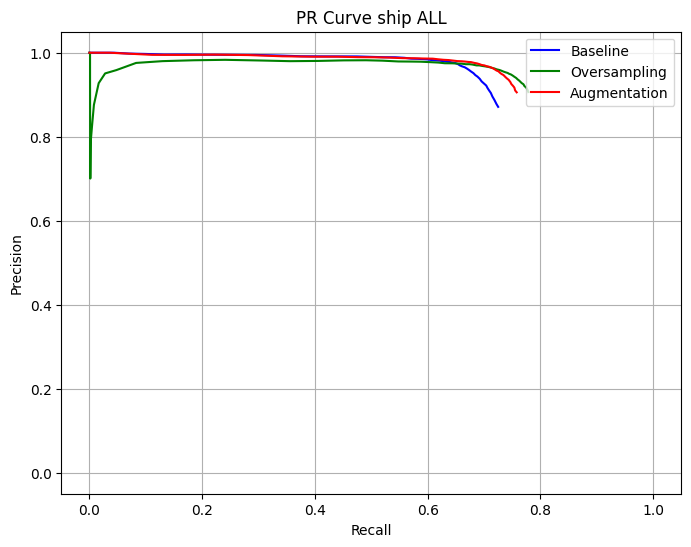

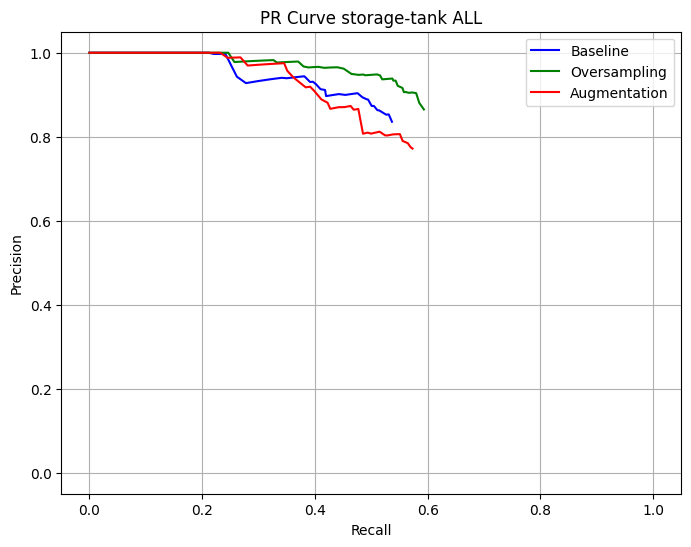

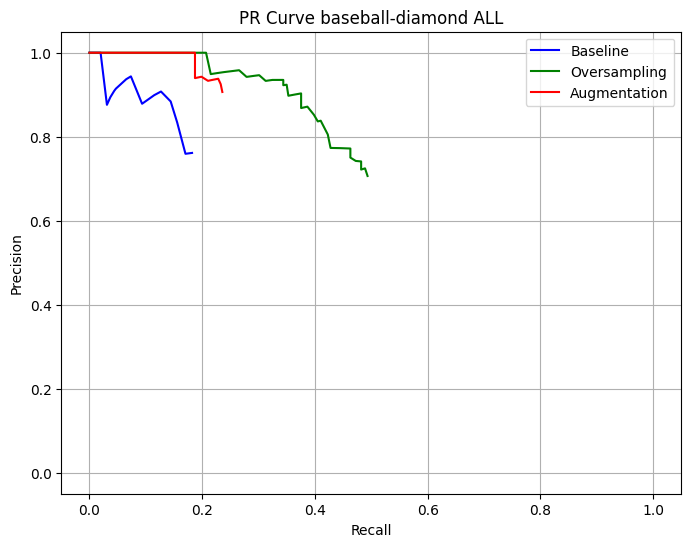

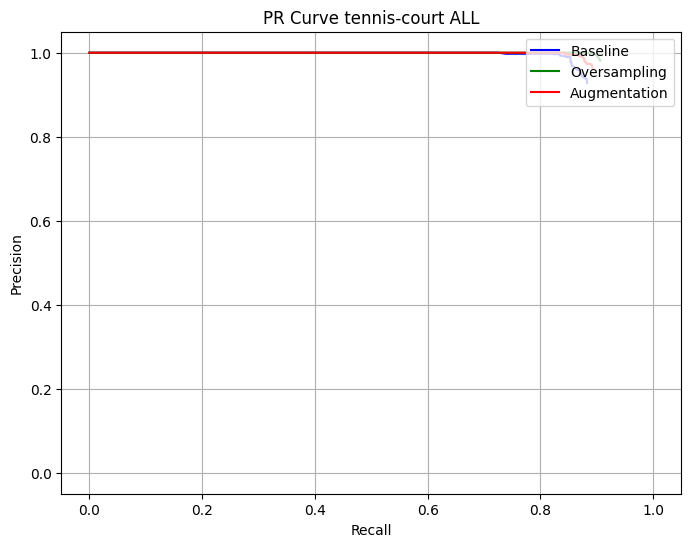

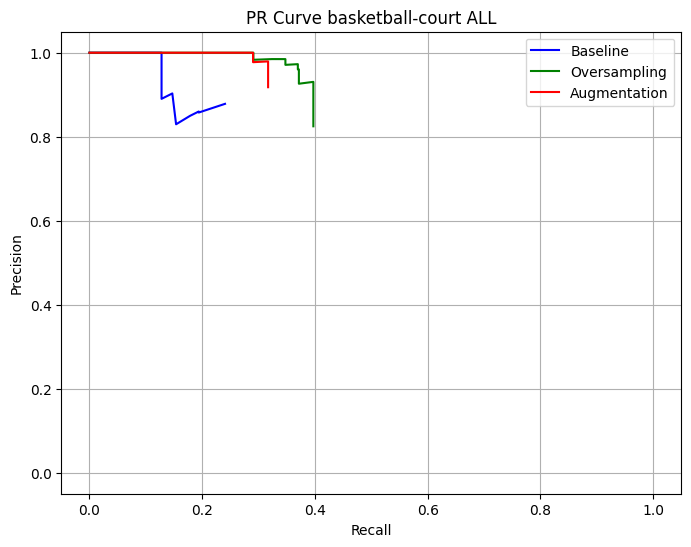

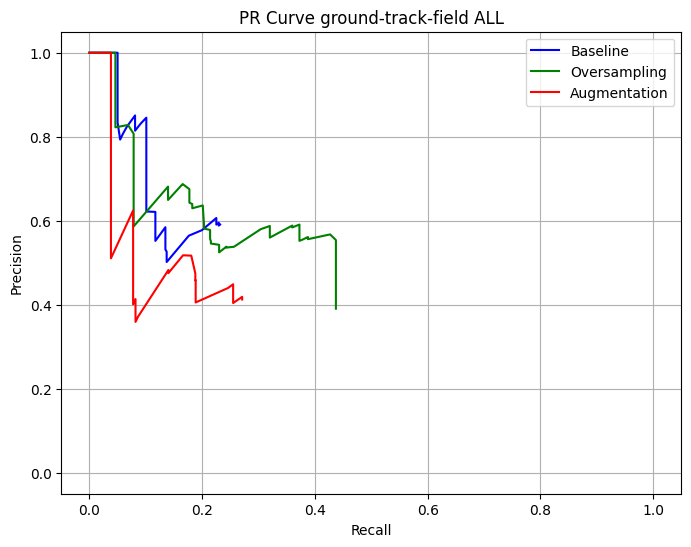

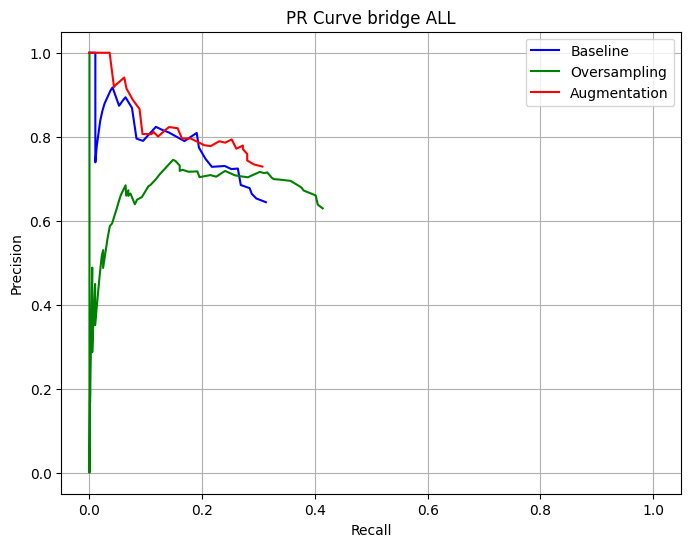

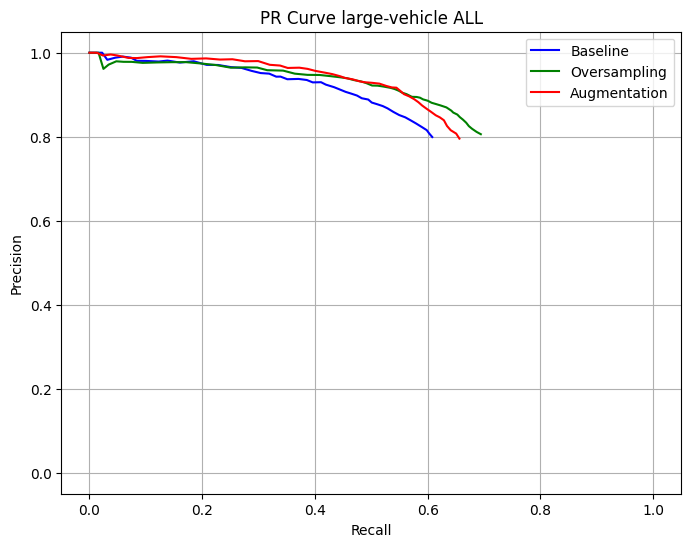

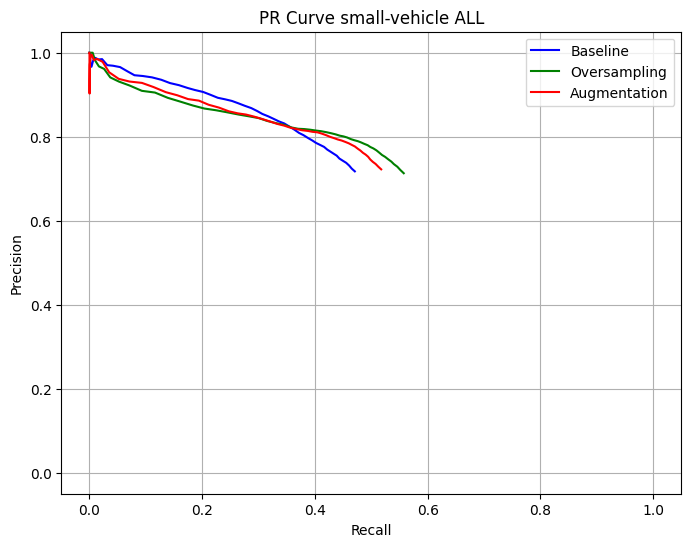

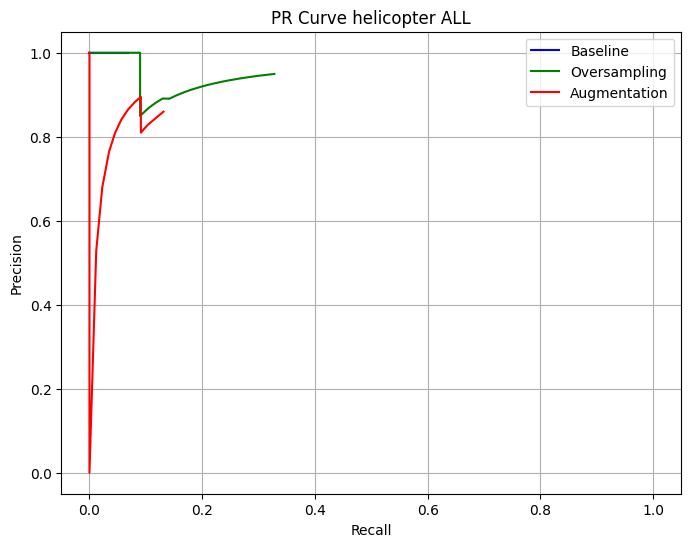

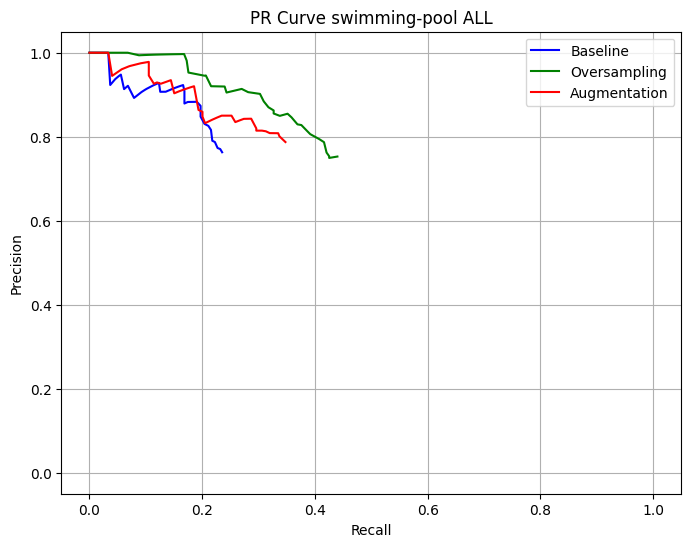

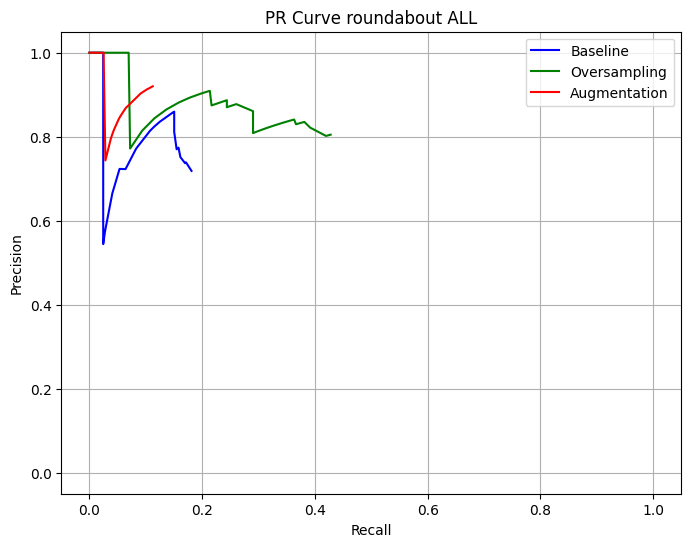

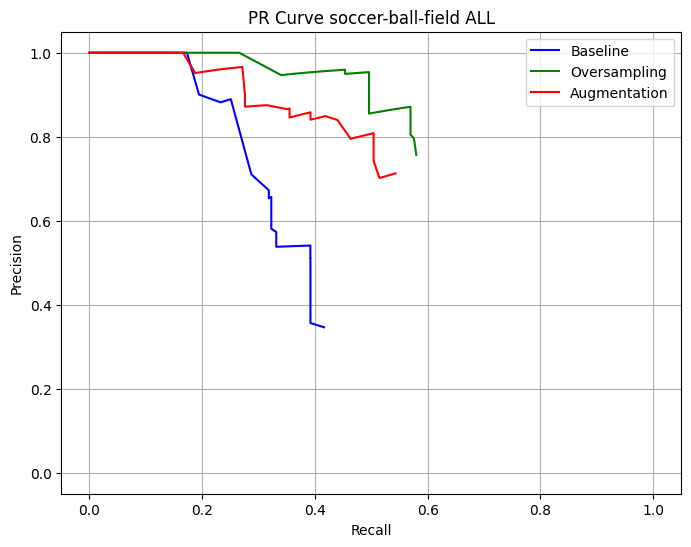

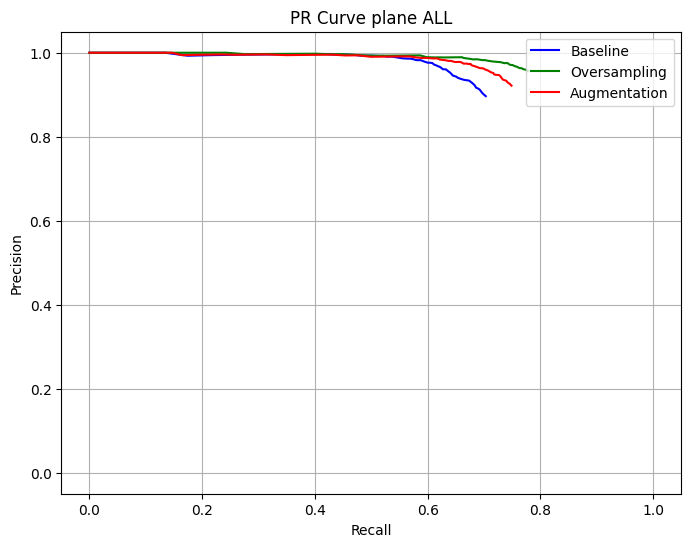

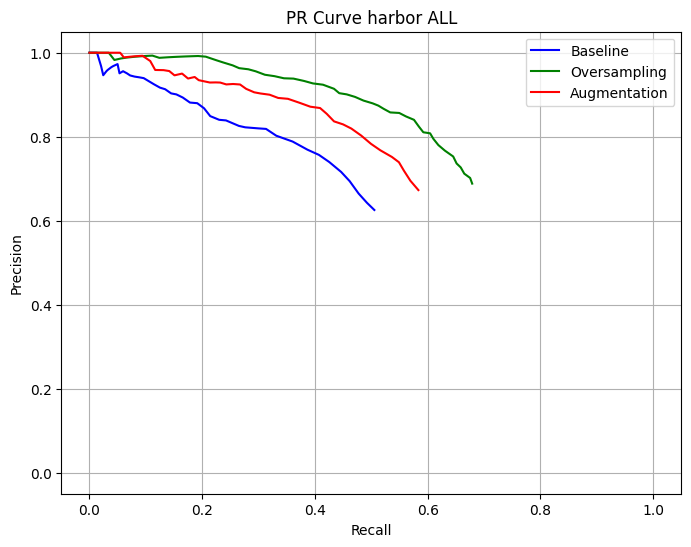

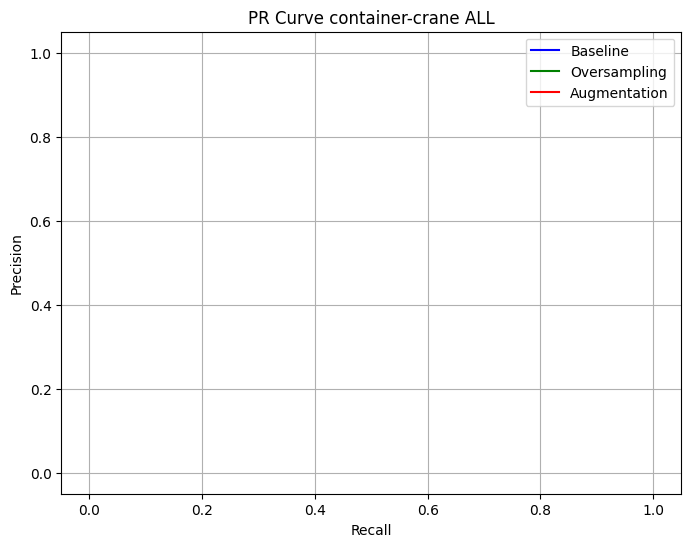

In [38]:
classes = [
    "ship", "storage-tank", "baseball-diamond", "tennis-court", 
    "basketball-court", "ground-track-field", "bridge", 
    "large-vehicle", "small-vehicle", "helicopter", "swimming-pool", 
    "roundabout", "soccer-ball-field", "plane", "harbor", 
    "container-crane"]
for cls in classes: 

    show_pr_curve(score_set_bl = sc_all_bl, #sc_all_bl, sc_diff_bl
                  score_set_os = sc_all_os, #sc_all_os, sc_diff_os
                  score_set_aug = sc_all_aug, #sc_all_aug, sc_diff_aug
                  class_name = cls)

#### Non-Maximum Suppression (NMS): 

To handle multiple detections of the same object, a technique called Non-Maximum Suppression is often applied:
- Predictions are sorted based on their confidence scores.
- Starting from the highest confidence score, each prediction is evaluated. If a prediction has a high IoU with a previously selected prediction (above the IoU threshold), it is considered a duplicate and suppressed.
- Only the prediction with the highest confidence score among duplicates is retained as a true positive.
- The duplicate is countes as FP -> We need a FP metric like FPR95

#### Calculate Average Precision

In [98]:
def calculate_AP(precision_recall_dict, name = "AP"):
    average_precision_dict = {}
    
    for cls, threshold_dict in precision_recall_dict.items():
        precisions = []
        recalls = []
            
        for threshold, metric_dict in threshold_dict.items():
            precision = metric_dict["precision"]
            recall = metric_dict["recall"]
            precisions.append(precision)
            recalls.append(recall)

        sorted_indices = np.argsort(recalls)
        sorted_recalls = np.array(recalls)[sorted_indices]
        sorted_precisions = np.array(precisions)[sorted_indices]
    
        average_precision = np.trapz(sorted_precisions, sorted_recalls)
        average_precision_dict[cls] = average_precision


    save_dir = "Average_Precision"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    csv_file = os.path.join(save_dir, name + ".csv")
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Class', 'Average Precision'])
        for key, value in average_precision_dict.items():
            writer.writerow([key, value])
    
    return average_precision_dict

In [99]:
AP_all = calculate_AP(sc_all, name = "AP_all")
AP_diff = calculate_AP(sc_diff, name = "AP_diff")
AP_easy= calculate_AP(sc_easy, name = "AP_easy")

In [100]:
def get_sorted_df_from_dict(dict):
    df = pd.DataFrame.from_dict(dict, orient='index', columns=['Average Precision'])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Class'}, inplace=True)
    df_sorted = df.sort_values(by='Average Precision', ascending=False)
    return df_sorted

In [101]:
df_AP_all = get_sorted_df_from_dict(AP_all)
df_AP_all

,Class,Average Precision
3,tennis-court,0.871221
13,plane,0.817313
0,ship,0.671698
7,large-vehicle,0.510666
10,swimming-pool,0.455935
8,small-vehicle,0.436331
5,ground-track-field,0.424863
14,harbor,0.219181
4,basketball-court,0.202647
12,soccer-ball-field,0.161657


In [102]:
df_AP_diff = get_sorted_df_from_dict(AP_diff)
df_AP_diff

,Class,Average Precision
5,ground-track-field,1.000000
13,plane,0.525661
8,small-vehicle,0.294337
7,large-vehicle,0.282671
12,soccer-ball-field,0.279201
0,ship,0.243532
14,harbor,0.044356
1,storage-tank,0.000000
2,baseball-diamond,0.000000
3,tennis-court,0.000000


In [103]:
df_AP_easy = get_sorted_df_from_dict(AP_easy)
df_AP_easy

,Class,Average Precision
3,tennis-court,0.872746
13,plane,0.820255
8,small-vehicle,0.796746
0,ship,0.711088
7,large-vehicle,0.543514
10,swimming-pool,0.539225
5,ground-track-field,0.328522
4,basketball-court,0.223379
14,harbor,0.223109
12,soccer-ball-field,0.146779


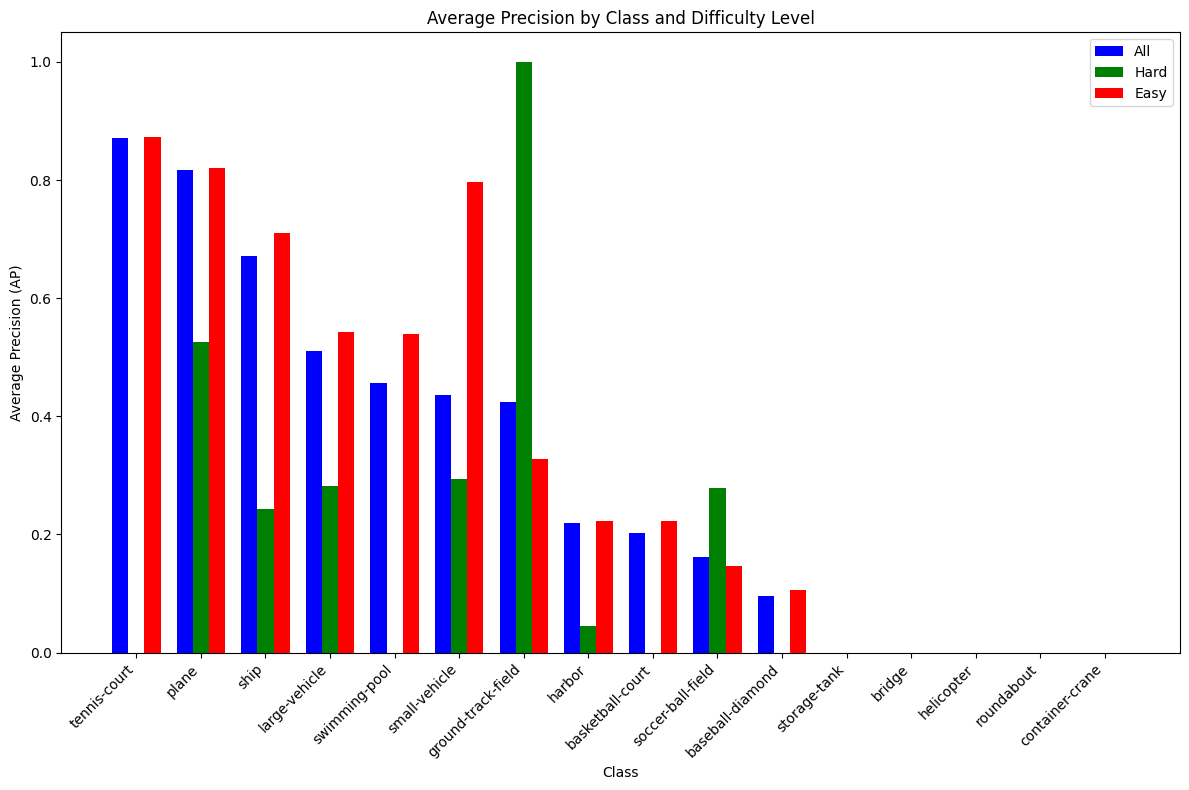

In [104]:
df_combined = df_AP_all.merge(df_AP_diff, on='Class').merge(df_AP_easy, on='Class')
df_combined = df_combined.rename(columns={
    'Average Precision_x': 'AP_all',
    'Average Precision_y': 'AP_diff',
    'Average Precision': 'AP_easy'
})
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.25
index = range(len(df_combined))

ax.bar(index, df_combined['AP_all'], bar_width, label='All', color='b')
ax.bar([i + bar_width for i in index], df_combined['AP_diff'], bar_width, label='Hard', color='g')
ax.bar([i + 2 * bar_width for i in index], df_combined['AP_easy'], bar_width, label='Easy', color='r')

ax.set_xlabel('Class')
ax.set_ylabel('Average Precision (AP)')
ax.set_title('Average Precision by Class and Difficulty Level')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(df_combined['Class'], rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()

In [105]:
def calculate_mAP(AP_dict):
    sum_ap = 0
    class_counter = 0
    for cls, ap in AP_dict.items():
        class_counter += 1
        sum_ap += ap
    mAP = sum_ap/class_counter
    return mAP

In [106]:
mAP_all = calculate_mAP(AP_all)
print(f"mAP for all instances: {round(100*mAP_all,2)}%")
mAP_diff = calculate_mAP(AP_diff)
print(f"mAP for hard to detect instances: {round(100*mAP_diff,2)}%")
mAP_easy = calculate_mAP(AP_easy)
print(f"mAP for easy instances: {round(100*mAP_easy,2)}%")

mAP for all instances: 30.42%
mAP for hard to detect instances: 16.69%
mAP for easy instances: 33.19%
